# Model Selection 

The objective of this notebook is to build a very first ent to end Machine Learning model to predict the probability of a patient being discharged on a particular day.

We'll use the dataset generated by the `dataset` job of the ETL folder. 

At this instance, the focus won't be on model performance but rather on understanding the value potential of the available data and the speedness of the solution.

In [1]:
%cd /Users/josefinadallavia/Documents/MIM/Tesis/AML-hospital

/Users/josefinadallavia/Documents/MIM/Tesis/AML-hospital


In [2]:
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
from matplotlib import pyplot as plt   
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from thesis_lib.utils import * 
from thesis_lib.modelling.data import *
from thesis_lib.modelling.model import *


In [3]:
data = Data().load('data/hospital_dataset')
variables = data.get_variables_dict()
data.get_stats()

Loading dataset:  hospital_train_data.parquet
Loading dataset:  hospital_val_data.parquet
Loading dataset:  hospital_test_data.parquet


dataset_type,train,val,test
n_observations,319150,33482,33309
relative_size,0.82694,0.0867542,0.0863059
n_cols,71,71,71
positives,42697,4555,4507
negatives,276453,28927,28802
positive_prop,0.133783,0.136043,0.135309
negative_prop,0.866217,0.863957,0.864691
min_date,2017-01-01,2018-11-11,2018-11-11
max_date,2018-11-10,2019-11-11,2019-11-11


In [4]:
text_features = ['administrative_diagnosis','presumptive_dianogsis','images_studies_names',
                'surgeries_actual']

In [25]:
text_features_extra  = ['labos_studies_names','sectors_names','images_study_types','surgeries_types',
                    'surgeries_injury_condition','surgeries_post_surgery_condition','surgeries_anesthesia_types',
 'administrative_diagnosis','presumptive_dianogsis','images_studies_names',
                'surgeries_actual']

In [6]:
len(text_features_extra)

11

In [7]:
categorical_features = ['date_weekday',
 'request_origin',
 'origin',
 'entity_group',
 'gender',
 'request_sector',
 'insurance_entity',
 'admission_sector',
 'emergency_service',
 'isolation',
 'ARM_TEP',
 'CEC_TEP',
 'request_sector',
 'date_weekday',
 'admission_weekday',
 'date_month',
 'admission_month']

In [8]:
numerical_features = ['PIM2TEP',
 'emergency_service',
 'high_risk_TEP',
 'hosp_day_number',
 'images_count',
 'images_cumulative',
 'images_emergencies',
 'images_requester_roles_count',
 'images_requesters_count',
 'images_study_types_count',
 'labos_count',
 'labos_cumulative',
 'labos_emergencies',
 'labos_requester_roles_count',
 'labos_requesters_count',
 'labos_set_count',
 'labos_set_cumulative',
 'low_risk_TEP',
 'new_born_gestation_age',
 'new_born_weight',
 'patient_age',
 'sectors_count',
 'sectors_last_stay',
 'surgeries_count',
 'surgeries_cumulative',
 'surgeries_post_surgery_duration',
 'surgeries_pre_surgery_duration',
 'surgeries_prep_duration',
 'surgeries_services_count',
 'surgeries_surgery_delay',
 'surgeries_surgery_duration',
 'surgeries_types_count']

### Text only

In [9]:
model_params = {'classifier': 'lgbm',
               'accepts_sparse': True,
                #'categorical_features' : categorical_features ,
                #'numerical_features' : numerical_features,
               'text_features': text_features,
               # 'sequence_features':sequence_features
               }

In [10]:
lgbm_text_features = Model(**model_params)
lgbm_text_features.transform(data)

Fitting pipeline...
Transforming data...


In [11]:
%%time
import time
start = time.time()
lgbm_text_features.fit_classifier()
end = time.time()

Training classifier


/Users/josefinadallavia/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[10]	training_set's auc: 0.69392	validation_set's auc: 0.668447
[20]	training_set's auc: 0.709845	validation_set's auc: 0.683521
[30]	training_set's auc: 0.722275	validation_set's auc: 0.692521
[40]	training_set's auc: 0.731797	validation_set's auc: 0.701275
[50]	training_set's auc: 0.738053	validation_set's auc: 0.706732
[60]	training_set's auc: 0.743902	validation_set's auc: 0.711759
[70]	training_set's auc: 0.748541	validation_set's auc: 0.715209
[80]	training_set's auc: 0.752249	validation_set's auc: 0.717535
[90]	training_set's auc: 0.755838	validation_set's auc: 0.719348
[100]	training_set's auc: 0.758008	validation_set's auc: 0.720087
CPU times: user 33.9 s, sys: 246 ms, total: 34.1 s
Wall time: 9.01 s


In [12]:
n = lgbm_text_features.n_features

In [13]:
perf = lgbm_text_features.get_performance_metrics()

training AUC ROC score:  0.7579774616121809
validation AUC ROC score:  0.7200873602224488
relative over-fitting:  0.04998842750435053


In [16]:
import seaborn as sns
sns.set(style="whitegrid",font_scale=1.2,font='AppleGothic', palette="rainbow")

In [13]:
# Write to the csv file ('a' means append)
import csv
out_file = 'experiments/output.csv'
of_connection = open(out_file, 'a')
writer = csv.writer(of_connection)
writer.writerow([4, 
                 'text_only', 
                 'gdbt', 
                 n,
                 end-start,
                 perf['auc_training'],
                 perf['auc_validation'],
                 perf['overfitting']
                ])
of_connection.close()

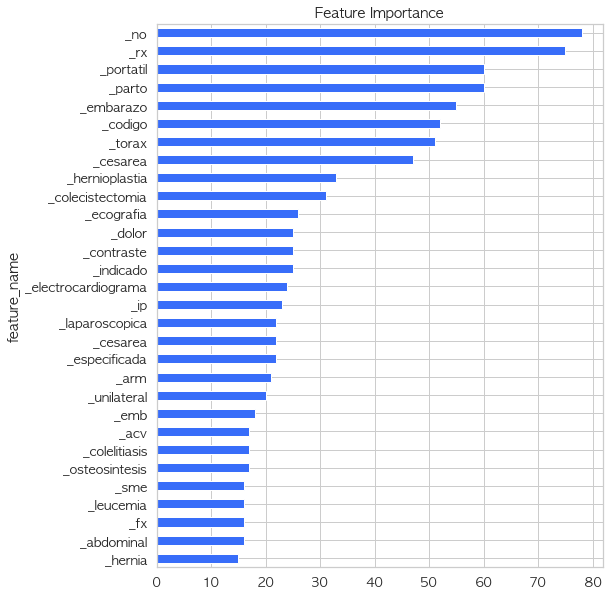

In [17]:
lgbm_text_features.plot_feature_importance()

### Sequence+ text 

In [26]:
model_params = {'classifier': 'lgbm',
               'accepts_sparse': True,
                #'categorical_features' : categorical_features ,
                #'numerical_features' : numerical_features,
               'text_features': text_features_extra,
                #'sequence_features':sequence_features
               }

In [27]:
text_features_extra

['labos_studies_names',
 'sectors_names',
 'images_study_types',
 'surgeries_types',
 'surgeries_injury_condition',
 'surgeries_post_surgery_condition',
 'surgeries_anesthesia_types',
 'administrative_diagnosis',
 'presumptive_dianogsis',
 'images_studies_names',
 'surgeries_actual']

In [28]:
lgbm_seq_features = Model(**model_params)
lgbm_seq_features.transform(data)


Fitting pipeline...
Transforming data...


In [29]:
%%time
start = time.time()
lgbm_seq_features.fit_classifier()
end = time.time()

Training classifier


/Users/josefinadallavia/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[10]	training_set's auc: 0.750152	validation_set's auc: 0.736573
[20]	training_set's auc: 0.760114	validation_set's auc: 0.744357
[30]	training_set's auc: 0.770291	validation_set's auc: 0.751234
[40]	training_set's auc: 0.775839	validation_set's auc: 0.754105
[50]	training_set's auc: 0.781147	validation_set's auc: 0.757505
[60]	training_set's auc: 0.785314	validation_set's auc: 0.761385
[70]	training_set's auc: 0.789256	validation_set's auc: 0.764112
[80]	training_set's auc: 0.792512	validation_set's auc: 0.765075
[90]	training_set's auc: 0.795504	validation_set's auc: 0.766736
[100]	training_set's auc: 0.798234	validation_set's auc: 0.76783
CPU times: user 1min 1s, sys: 702 ms, total: 1min 2s
Wall time: 17.7 s


In [30]:
perf = lgbm_seq_features.get_performance_metrics()

training AUC ROC score:  0.798194581403141
validation AUC ROC score:  0.7678298530875461
relative over-fitting:  0.038041762025265734


In [21]:
n= lgbm_seq_features.n_features

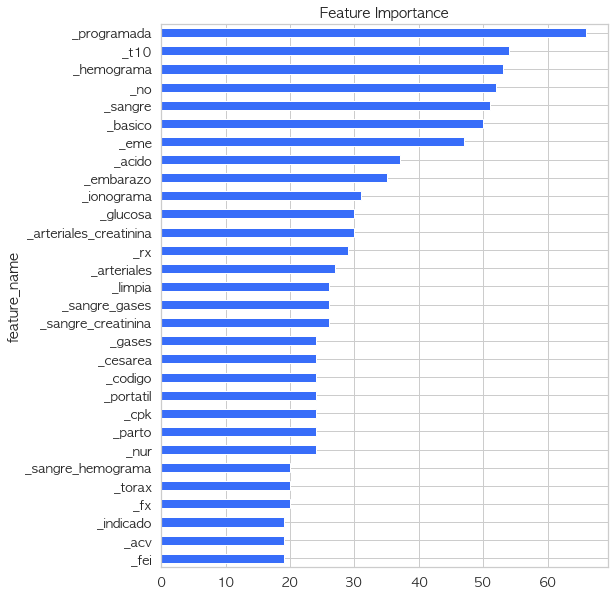

In [31]:
lgbm_seq_features.plot_feature_importance()

In [22]:
# Write to the csv file ('a' means append)
import csv
out_file = 'experiments/output.csv'
of_connection = open(out_file, 'a')
writer = csv.writer(of_connection)
writer.writerow([4, 
                 'text+sequence_only', 
                 'gdbt', 
                 n,
                 end-start,
                 perf['auc_training'],
                 perf['auc_validation'],
                 perf['overfitting']
                ])
of_connection.close()

### Random forest + text

In [32]:
model_params = {'classifier': 'random_forest',
               'accepts_sparse': True,
                #'categorical_features' : categorical_features ,
                #'numerical_features' : numerical_features,
               'text_features': text_features_extra
                #,
                #'sequence_features':sequence_features
               }

In [33]:
rf_comb_text_features = Model(**model_params)
rf_comb_text_features.transform(data)


Fitting pipeline...
Transforming data...


In [34]:
%%time
start = time.time()
rf_comb_text_features.fit_classifier()
end = time.time()

Training classifier


/Users/josefinadallavia/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[10]	training_set's auc: 0.719292	validation_set's auc: 0.70134
[20]	training_set's auc: 0.719497	validation_set's auc: 0.701652
[30]	training_set's auc: 0.721168	validation_set's auc: 0.703423
[40]	training_set's auc: 0.721815	validation_set's auc: 0.703561
[50]	training_set's auc: 0.724199	validation_set's auc: 0.706419
[60]	training_set's auc: 0.72416	validation_set's auc: 0.706297
[70]	training_set's auc: 0.724173	validation_set's auc: 0.706997
[80]	training_set's auc: 0.723912	validation_set's auc: 0.706959
[90]	training_set's auc: 0.723925	validation_set's auc: 0.706891
[100]	training_set's auc: 0.726638	validation_set's auc: 0.710153
CPU times: user 1min 11s, sys: 720 ms, total: 1min 11s
Wall time: 23.6 s


In [35]:
perf = rf_comb_text_features.get_performance_metrics()

training AUC ROC score:  0.726620965375375
validation AUC ROC score:  0.7101526204518684
relative over-fitting:  0.02266428538157988


In [36]:
n = rf_comb_text_features.n_features

In [28]:
# Write to the csv file ('a' means append)
import csv
out_file = 'experiments/output.csv'
of_connection = open(out_file, 'a')
writer = csv.writer(of_connection)
writer.writerow([4, 
                 'text+sequence_only', 
                 'rf', 
                 n,
                 end-start,
                 perf['auc_training'],
                 perf['auc_validation'],
                 perf['overfitting']
                ])
of_connection.close()

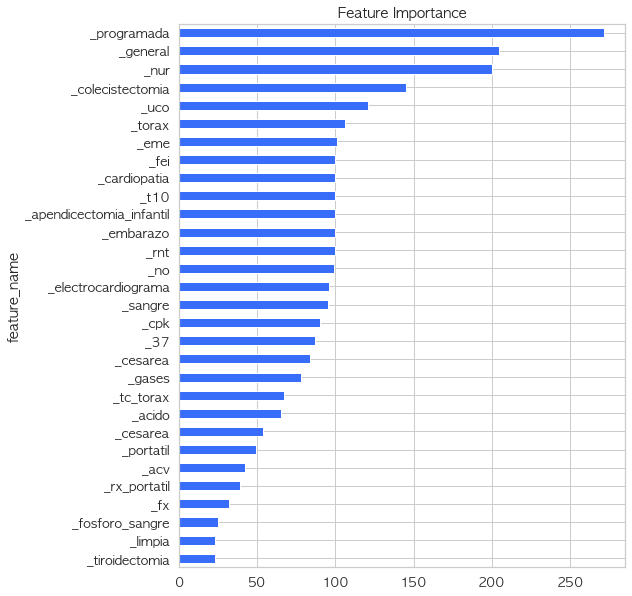

In [37]:
rf_comb_text_features.plot_feature_importance()

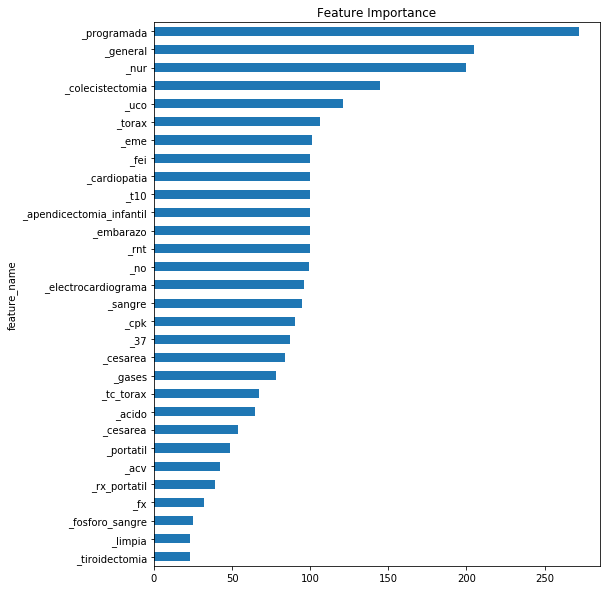

In [30]:
rf_comb_text_features.plot_feature_importance()

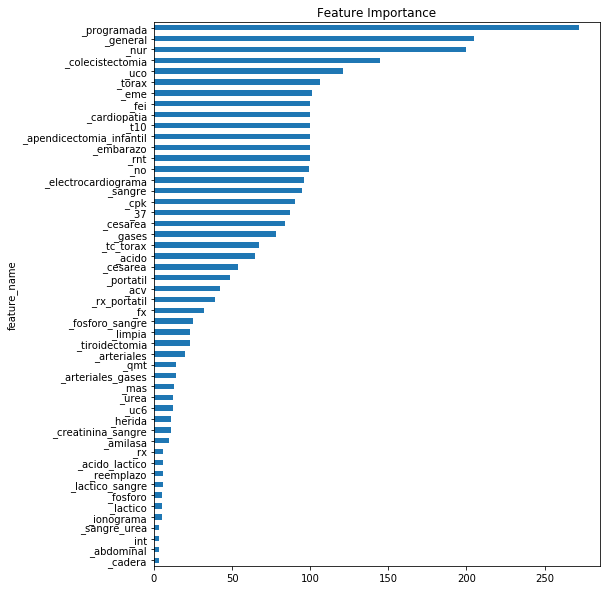

In [31]:
rf_comb_text_features.plot_feature_importance(50)